In [41]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'
import dask.dataframe as dd
from scipy.stats import norm

from sklearn.cluster import KMeans
import numpy as np

import pandas



/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_52009/1208524283.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [42]:
#load mobility and temperature data
#load heatwave - control dataframe
mobility_heat = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/india/THI_mobility_heat_clean_90.csv')
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/india/THI_heatwave_control_90.csv')

In [43]:
mobility_heat['control_day'] = pd.to_datetime(mobility_heat['control_day'])
mobility_heat['datetime'] = pd.to_datetime(mobility_heat['datetime'])

## Build Intensity Variable


In [44]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/india/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df.month.unique()
full_df = full_df[~full_df['month'].isin([8, 9])]
full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


In [45]:
#merge temperatures from control day onto mobility heat
mobility_heat = mobility_heat.merge(full_df[['datetime', 'thi', 'location']], left_on=['location', 'control_day'], right_on=['location', 'datetime'], suffixes=('_heat', '_control'))

In [46]:
(mobility_heat['thi_heat'] - mobility_heat['thi_control']).max()

16.535180698741573

In [47]:
np.corrcoef(mobility_heat['thi_heat'], mobility_heat['thi_control'])


array([[1.        , 0.93058852],
       [0.93058852, 1.        ]])

### Create/explore temperature difference variable

In [48]:
mobility_heat['thi_diff'] = mobility_heat['thi_heat'] - mobility_heat['thi_control']

In [49]:
mobility_heat['thi_diff'].describe()

count    6318.000000
mean        4.854015
std         2.357966
min         0.805934
25%         2.974889
50%         4.441723
75%         6.434542
max        16.535181
Name: thi_diff, dtype: float64

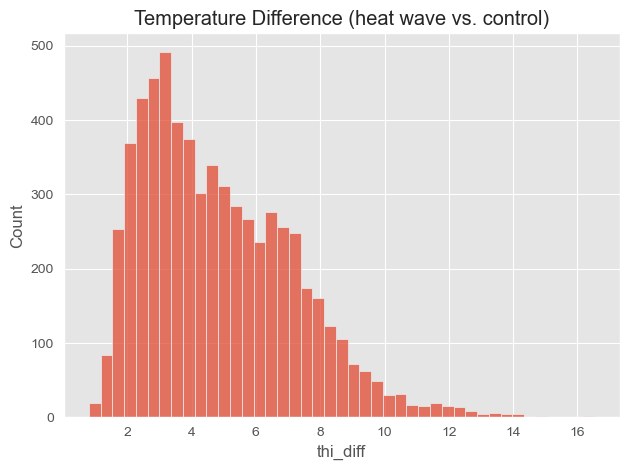

In [50]:
sns.histplot(mobility_heat, x='thi_diff')
plt.title("Temperature Difference (heat wave vs. control)")
plt.tight_layout()
plt.savefig(data_path + '/img/12_09_2023/india_temp_diff_dist.png')

### Build Duration Variable
* Duration of heat wave (in days)
* Build variable showing which day of a heatwave it is

In [51]:
# Formatting column names and merging dataframes

In [52]:
heatwave_control.sort_values(by='Heat Wave Duration', inplace=True)

In [53]:
duration_IDs = heatwave_control.drop_duplicates('heat_ID')[['heat_ID', 'Heat Wave Duration']  ]             

In [54]:
duration_IDs.columns = ['heat_ID', 'Heat Wave Duration']

In [55]:
duration_IDs.head()

,heat_ID,Heat Wave Duration
3787,9a58da7a-b3e8-487e-8572-9e26f4e91174,2.0
2003,2ed05498-ff19-43ae-8a62-4f69a2a99556,2.0
2005,17773d21-3363-4177-a20c-51a049e8ae30,2.0
2007,1ada4cc7-6b11-4cf2-bab4-874e409e8ee9,2.0
2009,bc0330ae-c639-4ead-8c6a-3c543db23007,2.0


In [56]:
duration_IDs['Heat Wave Duration'].describe()

count    1904.000000
mean        4.026786
std         2.939362
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        19.000000
Name: Heat Wave Duration, dtype: float64

In [57]:
#drop original heatwave duration variable
heatwave_control.drop('Heat Wave Duration', axis=1, inplace=True)

In [58]:
#merge duration ID dataframe onto heatwave control
heatwave_control = heatwave_control.merge(duration_IDs, on='heat_ID', how='left')

In [59]:
heatwave_control.drop_duplicates(['location', 'datetime'], inplace=True)

In [60]:
heatwave_control['dur_ranking'] = heatwave_control['Heat Wave Duration'].rank(pct=True)

In [61]:
#groupby each heatwave, sort by date, assign increasing rank for each passing day
heat_stage = heatwave_control.groupby('heat_ID').apply(lambda x: x.datetime.sort_values().rank()).reset_index()

In [62]:
heat_stage.columns=['heat_ID', 'index', 'stage']

In [63]:
heat_stage['stage'].max()

19.0

In [64]:
x = heat_stage.merge(duration_IDs, on='heat_ID')

In [65]:
heatwave_control.drop('index', axis=1, inplace=True)

In [66]:
heatwave_control.reset_index(inplace=True)

In [67]:
heatwave_control = heatwave_control.merge(heat_stage, on=['index', 'heat_ID'])

In [68]:
heatwave_control['datetime'] = pd.to_datetime(heatwave_control['datetime'])

In [69]:
heatwave_control['stage'].max()

19.0

In [70]:
mobility_heat['date_heat'] = pd.to_datetime(mobility_heat['date_heat'])

In [71]:
#merge temporal variables into mobility_heat

mobility_heat = mobility_heat.merge(heatwave_control[['location', 'datetime', 'Heat Wave Duration', 'dur_ranking', 'stage']], left_on=['location', 'date_heat'], right_on=['location', 'datetime'])

In [72]:
mobility_heat.reset_index(inplace=True)

In [73]:
mobility_heat['month'] = [x.month for x in mobility_heat['datetime']]

In [74]:
mobility_heat['month'].unique()

array([6, 7, 5, 4])

In [78]:
# format final variables
mobility_heat['stage_frac'] = (mobility_heat['stage'] / mobility_heat['Heat Wave Duration'] )
mobility_heat.drop_duplicates('heat_ID')['Heat Wave Duration'].describe()


count    1613.000000
mean        3.926224
std         2.776432
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        19.000000
Name: Heat Wave Duration, dtype: float64

In [79]:
mobility_heat['heatwave_dur'] = mobility_heat['Heat Wave Duration'] >= 4

In [80]:
mobility_heat['month'] = [x.month for x in pd.to_datetime(mobility_heat['date_control'])]

In [81]:
mobility_heat['date_control'] = pd.to_datetime(mobility_heat['date_control'])

## Merge social and physical variables

In [82]:
soc_phys = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/india/merged.shp')

In [83]:
mobility_heat= mobility_heat.merge(soc_phys[['location', 'mean_elev', 'coast', 'HDI_dec', 'popdens_de', 'over60_dec']], on='location')

In [84]:
mobility_heat['elev_1500m'] = mobility_heat['mean_elev'] >= 1500

In [85]:
mobility_heat['elev_1500m'] = mobility_heat['elev_1500m'] * 1

### Remove holidays 

In [86]:
import requests

In [87]:
hols_2022 = pd.DataFrame(requests.get("https://date.nager.at/api/v3/publicholidays/2022/ID").json())
hols_2022['date'] = pd.to_datetime(hols_2022['date'])

In [88]:
mobility_heat = mobility_heat[~mobility_heat['datetime_heat'].isin(hols_2022['date'].values)]
mobility_heat = mobility_heat[~mobility_heat['datetime_control'].isin(hols_2022['date'].values)]

## Normalized rain variable for heatwave and control day

In [89]:
precip = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/precipitation/india/daily_sum_precipitation.csv')
precip.rename(columns={'valid_time': 'time'}, inplace=True)
precip['time'] = pd.to_datetime(precip['time'])

In [90]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/india/clean_shp.shp')
gdf['location'] = gdf['adm2'] + ', ' + gdf['adm1']
gdf.to_crs(epsg='3857', inplace=True)
gdf['area'] = [x.area for x in gdf['geometry']]

In [91]:
#area from m --> km
#rain from m --> mm
precip['daily_precipitation'] = precip['daily_precipitation'] * 1000
gdf['area'] = gdf['area'] / 1000

In [92]:
precip = precip.merge(gdf[['location', 'area']], on='location')
precip['rain_normed'] = (precip['daily_precipitation'] / precip['area']) 

In [93]:
precip['rain_standard'] = precip.groupby('location')['rain_normed'].rank(pct=True) * 100

### Control day rain dummy

In [94]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['control_day', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [95]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_control"}, inplace=True)

### Heatwave day rain dummy

In [96]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['date_heat', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [97]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_heat"}, inplace=True)

### Prepare final dataset

In [98]:
df = mobility_heat.copy()

In [99]:
df = df[df['mean_elev'] <= 2500]

In [100]:
#set outlier cutoff (how many SDs away from mean)
SD = 4

In [102]:
for variable in ['workplace_difference', 'residential_difference', 'grocery_pharm_difference', 'parks_difference', 'retail_rec_difference', 'transit_difference']:
    
    df[variable] = [np.nan if (x >= df[variable].mean() + (SD * df[variable].std())) | (x <= df[variable].mean() - (SD * df[variable].std())) else x for x in df[variable] ]
    

    #v13
df.dropna(how='all', subset=['workplace_difference', 'residential_difference', 'transit_difference', 'grocery_pharm_difference', 'parks_difference', 'retail_rec_difference'], inplace=True)

In [103]:
df = df.iloc[:, 3:]
df['index'] = range(0, len(df))

In [104]:
df.reset_index(inplace=True)

In [105]:
df[['residential_difference', 'workplace_difference', 'transit_difference', 'grocery_pharm_difference', 'retail_rec_difference', 'parks_difference']].describe().transpose()[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
residential_difference,5417.0,0.123500,2.146516,-11.0,11.0
workplace_difference,5708.0,-1.720217,11.802506,-56.0,50.0
transit_difference,5320.0,0.659398,12.322703,-61.0,57.0
grocery_pharm_difference,4729.0,-3.588708,15.612434,-77.0,70.0
retail_rec_difference,5319.0,-2.823651,11.751698,-56.0,51.0
parks_difference,5058.0,0.550217,19.085156,-92.0,92.0


In [106]:
df.rename(columns={'workplace_difference': 'workplaces_difference'}, inplace=True)

In [107]:
df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/india/THI_mobility_heat_w_vars_90_{SD}SD_precip.csv')

In [167]:
plt.rcParams["image.cmap"] = 'Reds'



In [168]:
df[['residential_difference', 'workplace_difference', 'transit_difference', 'grocery_pharm_difference', 'retail_rec_difference', 'parks_difference']].describe().transpose()[['count', 'mean', 'std', 'min', 'max']].style.background_gradient(cmap=None)

,count,mean,std,min,max
residential_difference,9919.000000,0.184898,2.068959,-8.000000,8.000000
workplace_difference,10292.000000,-2.599786,10.676353,-47.000000,42.000000
transit_difference,9835.000000,2.097407,11.792183,-46.000000,50.000000
grocery_pharm_difference,8863.000000,-1.103802,14.034079,-58.000000,56.000000
retail_rec_difference,9789.000000,-0.795689,10.236593,-42.000000,40.000000
parks_difference,9318.000000,1.875402,17.225862,-69.000000,73.000000


In [3]:
df = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/india/THI_mobility_heat_w_vars_90_4SD.csv')

In [13]:
df.groupby('elev_1500m')['thi_heat'].describe().style.background_gradient(cmap=None)

,count,mean,std,min,25%,50%,75%,max
elev_1500m,,,,,,,,
0,5568.000000,41.545475,3.944329,26.374187,39.814339,42.442004,44.323891,49.439260
1,173.000000,23.842177,2.825217,19.090580,21.976141,23.148405,26.360503,30.555989


In [7]:
low_elev = df[df['elev_1500m'] == 0]

In [9]:
low_elev.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/india/low_elev_THI_mobility_heat_w_vars_90_4SD.csv')

In [ ]:
low